In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
import itertools
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.stats.api as sms
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import calendar
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import svm
from xgboost import XGBRegressor
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('cust_segmentation_Data.csv')

In [3]:
data.head(10)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2
5,6,40,1,23,81,0.998,7.831,NaN,10.9
6,7,38,2,4,56,0.442,0.454,0.0,1.6
7,8,42,3,0,64,0.279,3.945,0.0,6.6
8,9,26,1,5,18,0.575,2.215,NaN,15.5
9,10,47,3,23,115,0.653,3.947,0.0,4.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [5]:
data.isna().sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

In [6]:
data.isnull().sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

In [7]:
data.isin([0]).sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed      72
Income               0
Card Debt            0
Other Debt           0
Defaulted          517
DebtIncomeRatio      0
dtype: int64

In [8]:
# we have a couple of missing values in the dependent variable of the dataset
# we can try to perform imputation by prediction (training a model on the original observations to predict the missing values)

In [9]:
observed_data = data[data['Defaulted'].notna()]
missing_data = data[data['Defaulted'].isna()]

### EDA

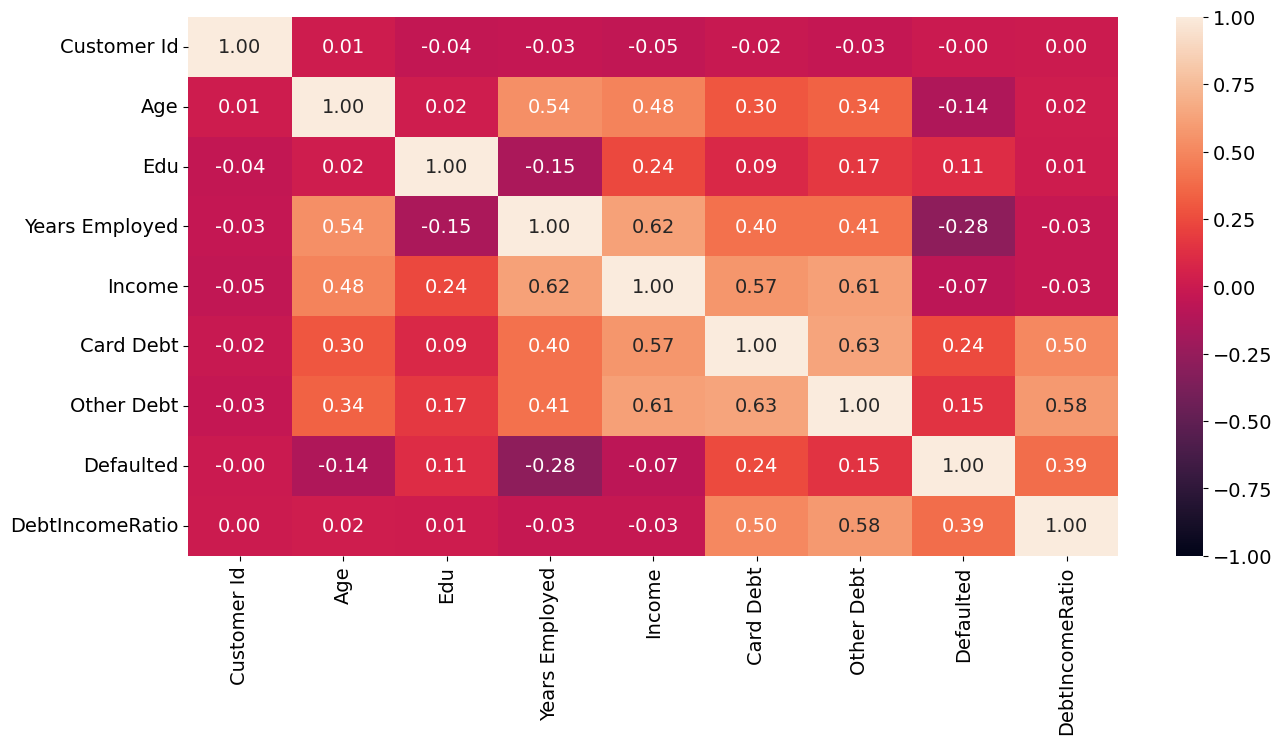

In [13]:
plt.figure(figsize=(15,7))
sns.heatmap(observed_data.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.savefig('heatmap.png', bbox_inches='tight')
plt.show();

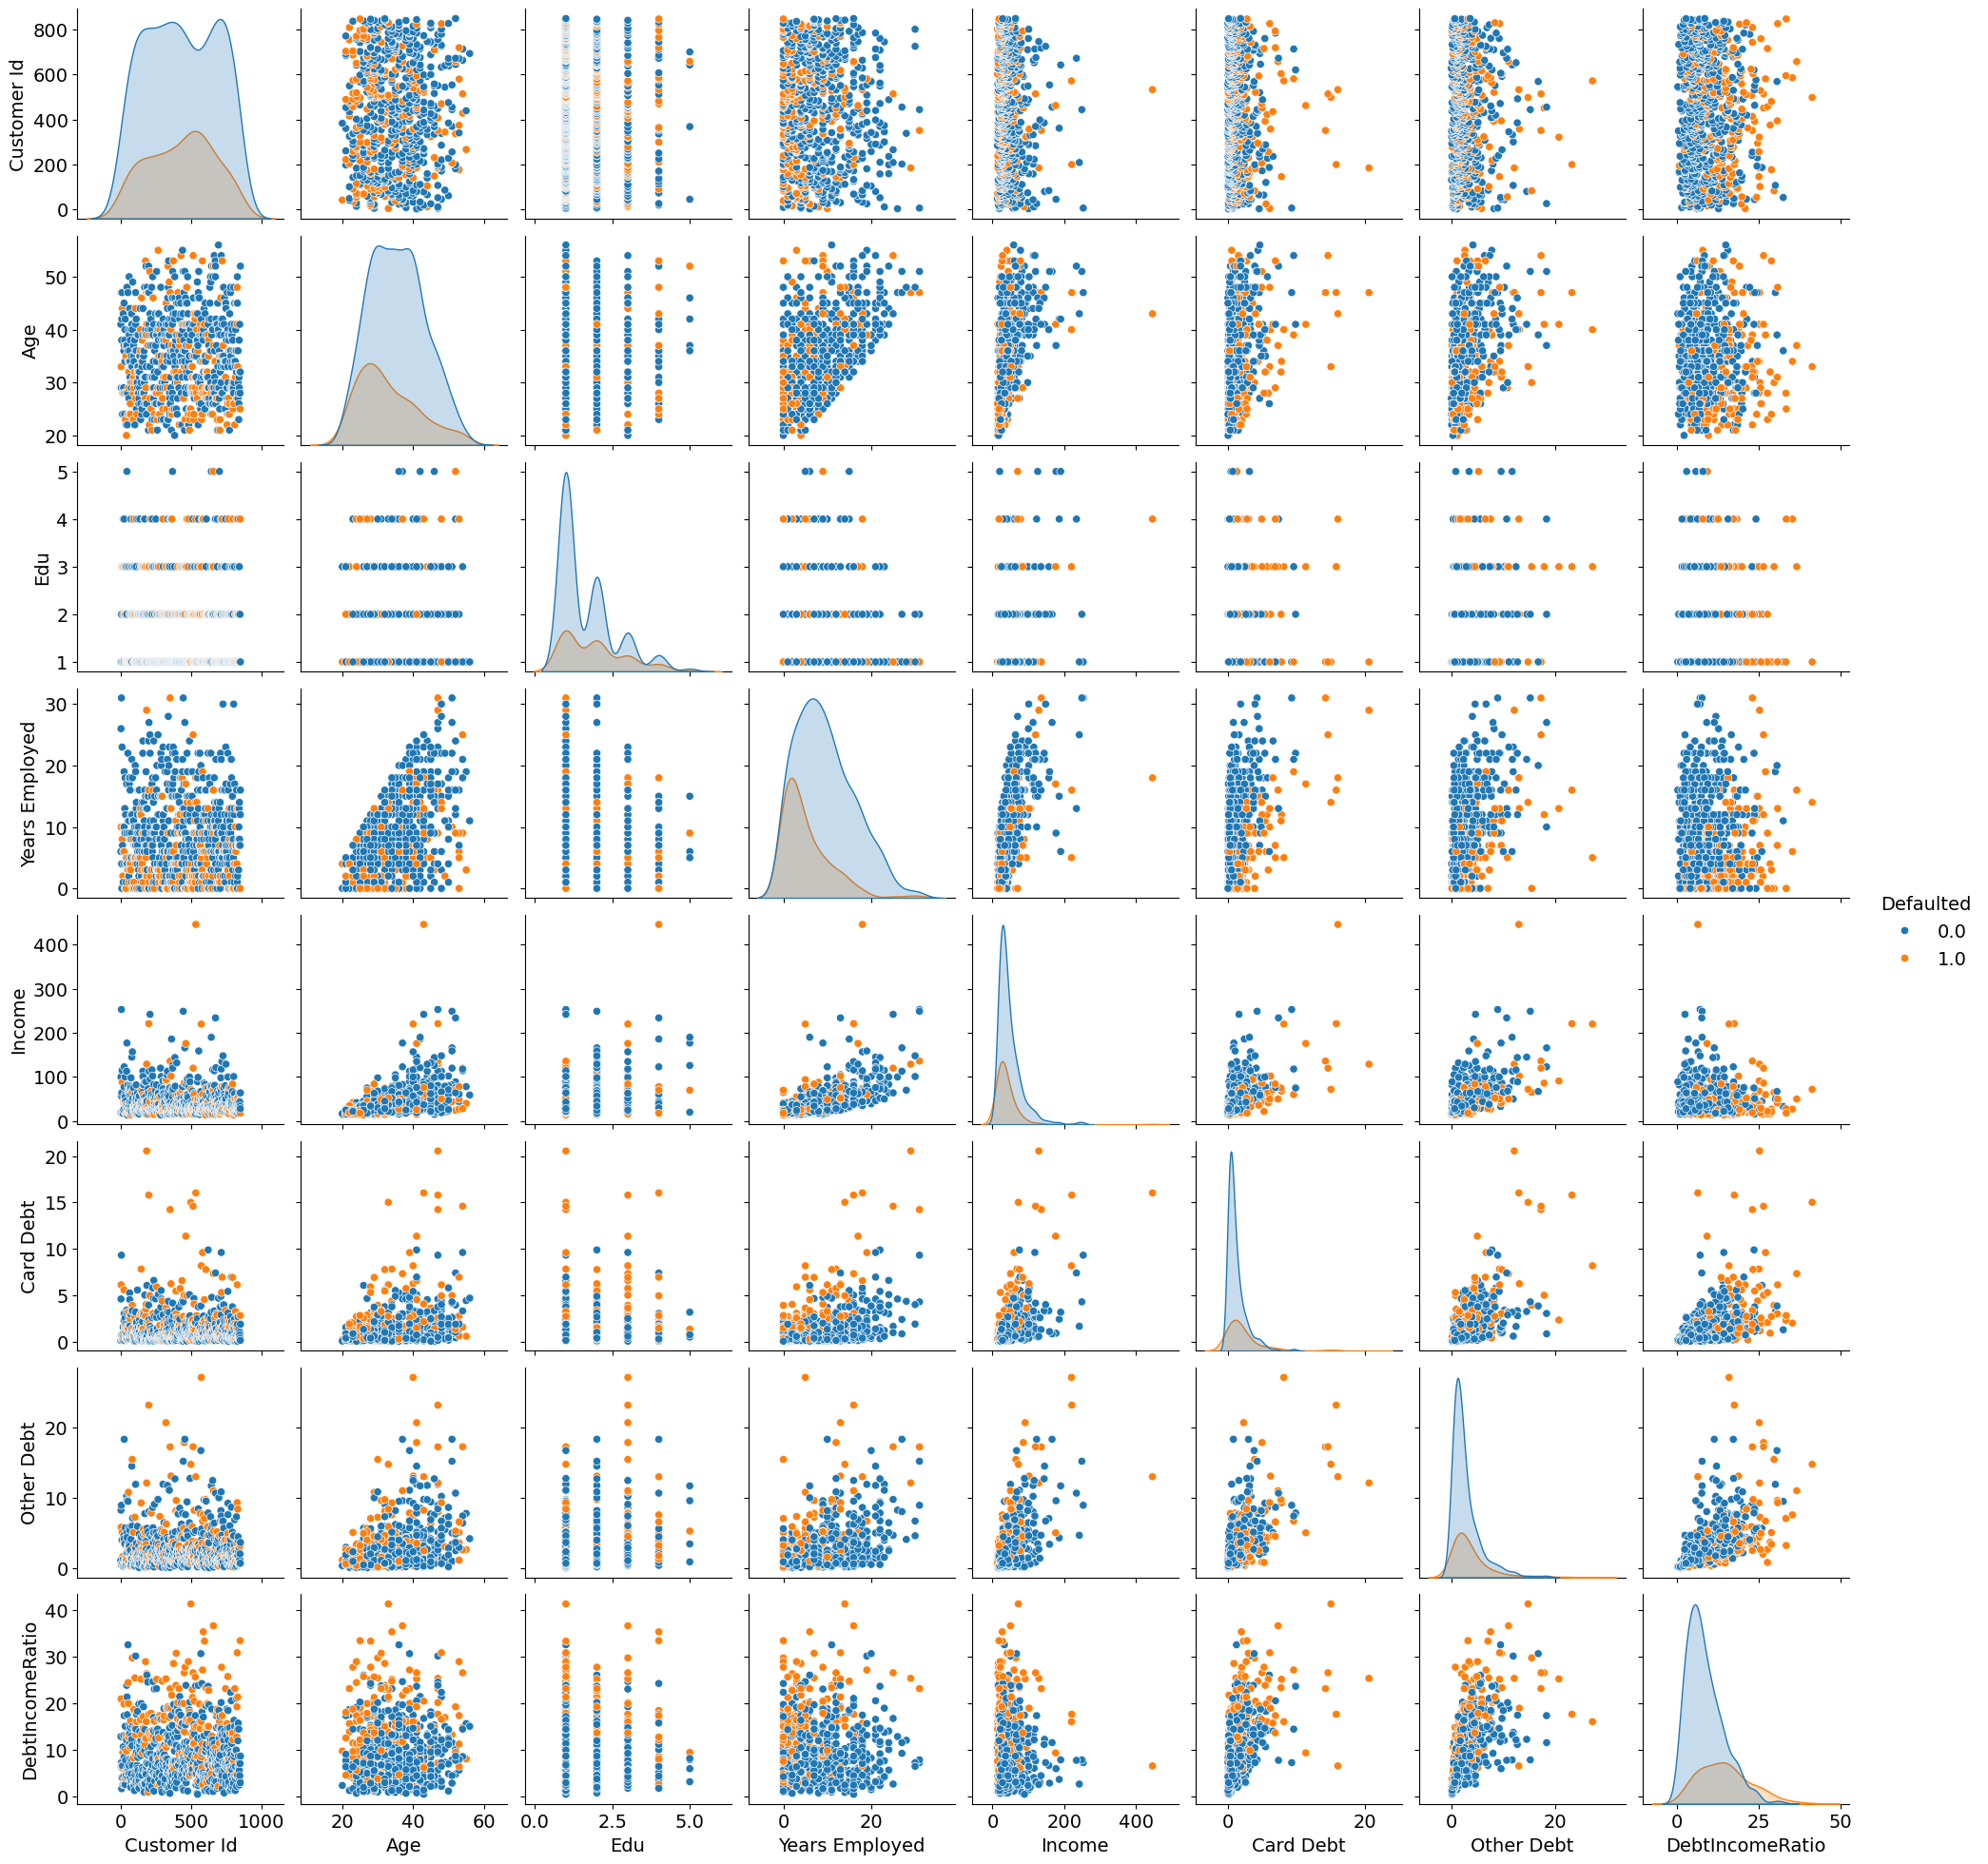

In [15]:
sns.pairplot(observed_data, hue='Defaulted')
plt.savefig('pairplot.png', bbox_inches='tight')
plt.show();

In [11]:
x = observed_data.drop(['Defaulted'], axis=1)
y = observed_data['Defaulted']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, stratify=y, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.4, stratify=y_val, random_state=1)

### XGBoost model for imputation using prediction

In [12]:
xgb = XGBClassifier(random_state=1)
param_dist={'n_estimators':np.arange(50,300,50),
            'learning_rate':np.arange(0.01,0.07,0.01),
            'max_depth':np.arange(1,5,1),
            'subsample':np.arange(0.4,0.9,0.1),
            'colsample_bytree':np.arange(0.5,0.9,0.1),
            'reg_alpha':np.arange(0,1,0.2),
            'reg_lambda':np.arange(1,4,0.5)}
recall_scorer = metrics.make_scorer(metrics.recall_score)
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, scoring=recall_scorer, cv=5, random_state=1, n_iter=150)
random_search.fit(x_train, y_train)
best_xgb = random_search.best_estimator_
best_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
pred_train_xgb = best_xgb.predict(x_train)
print(classification_report(y_train, pred_train_xgb))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       258
         1.0       0.84      0.71      0.77        92

    accuracy                           0.89       350
   macro avg       0.87      0.83      0.85       350
weighted avg       0.89      0.89      0.89       350



In [14]:
cm_train = confusion_matrix(y_train, pred_train_xgb)
custom_cm_xgb = pd.DataFrame([[cm_train[1,1],cm_train[1,0]],
                               [cm_train[0,1],cm_train[0,0]]],
                              columns=['Predicted Positive','Predicted Negative'],
                             index=['Actual Positive','Actual Negative'])
custom_cm_xgb

,Predicted Positive,Predicted Negative
Actual Positive,65,27
Actual Negative,12,246


#### predictions on the validation set

In [15]:
pred_val_xgb = best_xgb.predict(x_val)
print(classification_report(y_val, pred_val_xgb))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       155
         1.0       0.65      0.40      0.49        55

    accuracy                           0.79       210
   macro avg       0.73      0.66      0.68       210
weighted avg       0.77      0.79      0.77       210



In [16]:
cm_val = confusion_matrix(y_val, pred_val_xgb)
custom_cm_val = pd.DataFrame([[cm_val[1,1],cm_val[1,0]],
                              [cm_val[0,1],cm_val[0,0]]],
                             columns=['Predicted Positive','Predicted Negative'],
                             index=['Actual Positive','Actual Negative'])
custom_cm_val

,Predicted Positive,Predicted Negative
Actual Positive,22,33
Actual Negative,12,143


#### predictions on test data

In [17]:
pred_test_xgb = best_xgb.predict(x_test)
print(classification_report(y_test, pred_test_xgb))

              precision    recall  f1-score   support

         0.0       0.80      0.88      0.83       104
         1.0       0.50      0.36      0.42        36

    accuracy                           0.74       140
   macro avg       0.65      0.62      0.63       140
weighted avg       0.72      0.74      0.73       140



In [18]:
cm_test = confusion_matrix(y_test, pred_test_xgb)
custom_cm_test = pd.DataFrame([[cm_test[1,1],cm_test[1,0]],
                               [cm_test[0,1], cm_test[0,0]]],
                              columns=['Predicted Positive','Predicted Negative'],
                              index=['Actual Positive','Actual Negative'])
custom_cm_test

,Predicted Positive,Predicted Negative
Actual Positive,13,23
Actual Negative,13,91


### Applying predictions to the missing values in the dependent variable

In [19]:
x_missing = missing_data.drop(['Defaulted'], axis=1)
imputed_y_prediction = best_xgb.predict(x_missing)

In [20]:
data1 = data.copy()

In [21]:
data1.loc[data['Defaulted'].isna(),['Defaulted']] = imputed_y_prediction

In [22]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        850 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [23]:
# there are a few methods to check the performance or accuracy of the predictions on the original data
# but these predictions are very time consuming and complicated, so we will go forward with the model building

## Analysis on the complete dataset

In [24]:
# since out predictions on the missing values of the dependent variable had okayish accuracy, we will assign sample weights for further model building
# i.e. full weight will be assigned to the original values in the dependent variable, and lower weights will be assigned to the predicted values.

In [25]:
data1['Weight'] = 1
data1.loc[data['Defaulted'].isna(),'Weight'] = 0.65

In [26]:
data1.head(10)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Weight
0,1,41,2,6,19,0.124,1.073,0.0,6.3,1.00
1,2,47,1,26,100,4.582,8.218,0.0,12.8,1.00
2,3,33,2,10,57,6.111,5.802,1.0,20.9,1.00
3,4,29,2,4,19,0.681,0.516,0.0,6.3,1.00
4,5,47,1,31,253,9.308,8.908,0.0,7.2,1.00
5,6,40,1,23,81,0.998,7.831,0.0,10.9,0.65
6,7,38,2,4,56,0.442,0.454,0.0,1.6,1.00
7,8,42,3,0,64,0.279,3.945,0.0,6.6,1.00
8,9,26,1,5,18,0.575,2.215,0.0,15.5,0.65
9,10,47,3,23,115,0.653,3.947,0.0,4.0,1.00


### Splitting the dataset

In [27]:
x1 = data1.drop(['Defaulted'], axis=1)
y1 = data1['Defaulted']
weight1 = data1['Weight']
x_train1,x_val1,y_train1,y_val1,weight_train1, weight_val1 = train_test_split(x1, y1, weight1,test_size=0.5, random_state=1, stratify=y1)
x_val1,x_test1,y_val1,y_test1,weight_val1, weight_test1 = train_test_split(x_val1,y_val1, weight_val1,test_size=0.4, random_state=1, stratify=y_val1)

### Logistic Regression

In [28]:
lg = LogisticRegression()
lg.fit(x_train1,y_train1, sample_weight=weight_train1)

LogisticRegression()

In [29]:
pred_train_lg = lg.predict(x_train1)
print(classification_report(y_train1, pred_train_lg))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       324
         1.0       0.64      0.46      0.53       101

    accuracy                           0.81       425
   macro avg       0.74      0.69      0.71       425
weighted avg       0.80      0.81      0.80       425



In [30]:
cm_lg_train = confusion_matrix(y_train1, pred_train_lg)
custom_cm_lg_train = pd.DataFrame([[cm_lg_train[1,1],cm_lg_train[1,0]],
                                   [cm_lg_train[0,1],cm_lg_train[0,0]]],
                                  columns=['Predicted Positive','Predicted Negative'],
                                  index=['Actual Positive','Actual Negative'])
custom_cm_lg_train

,Predicted Positive,Predicted Negative
Actual Positive,46,55
Actual Negative,26,298


#### Predicting LG on validation set

In [31]:
pred_val_lg = lg.predict(x_val1)
print(classification_report(y_val1, pred_val_lg))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89       194
         1.0       0.65      0.52      0.58        61

    accuracy                           0.82       255
   macro avg       0.76      0.72      0.73       255
weighted avg       0.81      0.82      0.81       255



In [32]:
cm_val_lg = confusion_matrix(y_val1, pred_val_lg)
custom_cm_val_lg = pd.DataFrame([[cm_val_lg[1,1],cm_val_lg[1,0]],
                                 [cm_val_lg[0,1],cm_val_lg[0,0]]],
                                columns=['Predicted Positive','Predicted Negative'],
                                index=['Actual Positive','Actual Negative'])
custom_cm_val_lg

,Predicted Positive,Predicted Negative
Actual Positive,32,29
Actual Negative,17,177


In [91]:
model_results = pd.DataFrame({'Model':['Logistic Regression'], 'Accuracy':[accuracy_score(y_val1, pred_val_lg)]})
model_results

,Model,Accuracy
0,Logistic Regression,0.819608


### Decision tree model

In [34]:
dtree = DecisionTreeClassifier(random_state=1)
param_dist_dt = {'max_depth':np.arange(1,7,1),
                 'min_samples_split':[2,5,7,10],
                 'min_samples_leaf':np.arange(1,11,2),
                 'max_leaf_nodes':np.arange(1,11,2),
                 'min_impurity_decrease':[0.001,0.01,0.1]}
recall_scorer = metrics.make_scorer(metrics.recall_score)
random_search = RandomizedSearchCV(dtree, param_distributions=param_dist_dt, scoring=recall_scorer, cv=5, random_state=1, n_iter=100)
random_search.fit(x_train1, y_train1, sample_weight=weight_train1)
best_dtree = random_search.best_estimator_
best_dtree.fit(x_train1, y_train1, sample_weight=weight_train1)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=5,
                       min_impurity_decrease=0.001, min_samples_leaf=3,
                       min_samples_split=10, random_state=1)

In [35]:
pred_train_dt = best_dtree.predict(x_train1)
print(classification_report(y_train1, pred_train_dt))

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       324
         1.0       0.72      0.39      0.50       101

    accuracy                           0.82       425
   macro avg       0.78      0.67      0.70       425
weighted avg       0.81      0.82      0.80       425



In [36]:
cm_train_dt = confusion_matrix(y_train1, pred_train_dt)
custom_cm_train_dt = pd.DataFrame([[cm_train_dt[1,1],cm_train_dt[1,0]],
                                   [cm_train_dt[0,1],cm_train_dt[0,0]]],
                                  columns=['Predicted Positive','Predicted Negative'],
                                  index=['Actual Positive','Actual Negative'])
custom_cm_train_dt

,Predicted Positive,Predicted Negative
Actual Positive,39,62
Actual Negative,15,309


#### Predicting dtree on validation dataset

In [37]:
pred_val_dt = best_dtree.predict(x_val1)
print(classification_report(y_val1, pred_val_dt))

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       194
         1.0       0.61      0.31      0.41        61

    accuracy                           0.79       255
   macro avg       0.71      0.62      0.64       255
weighted avg       0.76      0.79      0.76       255



In [38]:
cm_val_dt = confusion_matrix(y_val1, pred_val_dt)
custom_cm_val_dt = pd.DataFrame([[cm_val_dt[1,1],cm_val_dt[1,0]],
                                 [cm_val_dt[0,1],cm_val_dt[0,0]]],
                                columns=['Predicted Positive','Predicted Negative'],
                                index=['Actual Positive','Actual Negative'])
custom_cm_val_dt

,Predicted Positive,Predicted Negative
Actual Positive,19,42
Actual Negative,12,182


In [92]:
dtree_results = pd.DataFrame({'Model':['Decision Tree'],'Accuracy':[accuracy_score(y_val1, pred_val_dt)]})
model_results = pd.concat([model_results, dtree_results], ignore_index=True)
model_results # reminder: we are only measuring validation set scores for performance metrics throughout all models

,Model,Accuracy
0,Logistic Regression,0.819608
1,Decision Tree,0.788235


### Random Forest

In [40]:
rf_model = RandomForestClassifier(random_state=1)
param_dist_rf = {'n_estimators':np.arange(50,350,50),
                 'max_depth':np.arange(1,6,1),
                 'min_samples_leaf':np.arange(1,11,2),
                 'min_samples_split':np.arange(1,11,2),
                 'max_features':np.arange(0.1,0.7,0.1)}
recall_scorer_rf = metrics.make_scorer(metrics.recall_score)
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist_rf, scoring=recall_scorer_rf, n_iter=50, cv=5, random_state=1)
random_search_rf.fit(x_train1, y_train1, sample_weight=weight_train1)
best_rf_model = random_search_rf.best_estimator_
best_rf_model.fit(x_train1, y_train1, sample_weight=weight_train1)

RandomForestClassifier(max_depth=5, max_features=0.6, min_samples_split=3,
                       n_estimators=50, random_state=1)

In [41]:
pred_train_rf = best_rf_model.predict(x_train1)
print(classification_report(y_train1, pred_train_rf))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       324
         1.0       0.95      0.70      0.81       101

    accuracy                           0.92       425
   macro avg       0.93      0.85      0.88       425
weighted avg       0.92      0.92      0.92       425



In [42]:
cm_train_rf = confusion_matrix(y_train1, pred_train_rf)
custom_cm_train_rf = pd.DataFrame([[cm_train_rf[1,1],cm_train_rf[1,0]],
                                   [cm_train_rf[0,1],cm_train_rf[0,0]]],
                                   columns=['Predicted Positive','Predicted Negative'],
                                  index=['Actual Positive','Actual Negative'])
custom_cm_train_rf

,Predicted Positive,Predicted Negative
Actual Positive,71,30
Actual Negative,4,320


#### Predicting RF on validation dataset

In [43]:
pred_val_rf = best_rf_model.predict(x_val1)
print(classification_report(y_val1, pred_val_rf))

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       194
         1.0       0.69      0.48      0.56        61

    accuracy                           0.82       255
   macro avg       0.77      0.70      0.73       255
weighted avg       0.81      0.82      0.81       255



In [44]:
cm_val_rf = confusion_matrix(y_val1, pred_val_rf)
custom_cm_val_rf = pd.DataFrame([[cm_val_rf[1,1],cm_val_rf[1,0]],
                                 [cm_val_rf[0,1],cm_val_rf[0,0]]],
                                columns=['Predicted Positive','Predicted Negative'],
                                index=['Actual Positive','Actual Negative'])
custom_cm_val_rf

,Predicted Positive,Predicted Negative
Actual Positive,29,32
Actual Negative,13,181


In [93]:
rf_results = pd.DataFrame({'Model':['Random Forest'], 'Accuracy':[accuracy_score(y_val1, pred_val_rf)]})
model_results = pd.concat([model_results,rf_results], ignore_index=True)
model_results

,Model,Accuracy
0,Logistic Regression,0.819608
1,Decision Tree,0.788235
2,Random Forest,0.823529


### Support Vector Machines

In [46]:
#SVM requires scaling of the features, since it is a distance based model

In [47]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train1)
x_val_scaled = scaler.transform(x_val1)

In [48]:
svm = SVC()
svm.fit(x_train_scaled, y_train1, sample_weight=weight_train1)

SVC()

In [49]:
pred_train_svm = svm.predict(x_train_scaled)
print(classification_report(y_train1, pred_train_svm))

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       324
         1.0       0.82      0.41      0.54       101

    accuracy                           0.84       425
   macro avg       0.83      0.69      0.72       425
weighted avg       0.84      0.84      0.82       425



In [50]:
cm_train_svm = confusion_matrix(y_train1, pred_train_svm)
custom_cm_train_svm = pd.DataFrame([[cm_train_svm[1,1],cm_train_svm[1,0]],
                                    [cm_train_svm[0,1],cm_train_svm[0,0]]],
                                   columns=['Predicted Positive','Predicted Negative'],
                                   index=['Actual Positive','Actual Negative'])
custom_cm_train_svm

,Predicted Positive,Predicted Negative
Actual Positive,41,60
Actual Negative,9,315


#### Predictions on the validation dataset

In [51]:
pred_val_svm = svm.predict(x_val_scaled)
print(classification_report(y_val1, pred_val_svm))

              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88       194
         1.0       0.71      0.28      0.40        61

    accuracy                           0.80       255
   macro avg       0.76      0.62      0.64       255
weighted avg       0.79      0.80      0.77       255



In [53]:
cm_val_svm = confusion_matrix(y_val1, pred_val_svm)
custom_cm_val_svm = pd.DataFrame([[cm_val_svm[1,1],cm_val_svm[1,0]],
                                  [cm_val_svm[0,1],cm_val_svm[0,0]]],
                                 columns=['Predicted Positive','Predicted Negative'],
                                 index=['Actual Positive','Actual Negative'])
custom_cm_val_svm

,Predicted Positive,Predicted Negative
Actual Positive,17,44
Actual Negative,7,187


In [94]:
svm_results = pd.DataFrame({'Model':['Support Vector Machines'], 'Accuracy':[accuracy_score(y_val1, pred_val_svm)]})
model_results = pd.concat([model_results, svm_results], ignore_index=True)
model_results

,Model,Accuracy
0,Logistic Regression,0.819608
1,Decision Tree,0.788235
2,Random Forest,0.823529
3,Support Vector Machines,0.800000


### KNN

In [62]:
KNN = KNeighborsClassifier()
KNN.fit(x_train1, y_train1) #KNN doesnt accept the sample_weight argument in the fit() function

KNeighborsClassifier()

In [63]:
# we will still train the model for practice

In [64]:
pred_train_knn = KNN.predict(x_train1)

In [65]:
print(classification_report(y_train1, pred_train_knn))

              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       324
         1.0       0.80      0.33      0.46       101

    accuracy                           0.82       425
   macro avg       0.81      0.65      0.68       425
weighted avg       0.82      0.82      0.79       425



In [66]:
cm_train_knn = confusion_matrix(y_train1, pred_train_knn)
custom_cm_train_knn = pd.DataFrame([[cm_train_knn[1,1],cm_train_knn[1,0]],
                                    [cm_train_knn[0,1],cm_train_knn[0,0]]],
                                   columns=['Predicted Positive','Predicted Negative'],
                                   index=['Actual Positive','Actual Negative'])
custom_cm_train_knn

,Predicted Positive,Predicted Negative
Actual Positive,33,68
Actual Negative,8,316


#### Prediction on the validation set

In [67]:
pred_val_knn = KNN.predict(x_val1)
print(classification_report(y_val1, pred_val_knn))

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       194
         1.0       0.47      0.15      0.23        61

    accuracy                           0.76       255
   macro avg       0.63      0.55      0.54       255
weighted avg       0.71      0.76      0.70       255



In [68]:
cm_val_knn = confusion_matrix(y_val1, pred_val_knn)
custom_cm_val_knn = pd.DataFrame([[cm_val_knn[1,1],cm_val_knn[1,0]],
                                  [cm_val_knn[0,1],cm_val_knn[0,0]]],
                                 columns=['Predicted Positive','Predicted Negative'],
                                 index=['Actual Positive','Actual Negative'])
custom_cm_val_knn

,Predicted Positive,Predicted Negative
Actual Positive,9,52
Actual Negative,10,184


In [95]:
knn_results = pd.DataFrame({'Model':['KNN'], 'Accuracy':[accuracy_score(y_val1, pred_val_knn)]})
model_results = pd.concat([model_results, knn_results], ignore_index=True)
model_results

,Model,Accuracy
0,Logistic Regression,0.819608
1,Decision Tree,0.788235
2,Random Forest,0.823529
3,Support Vector Machines,0.800000
4,KNN,0.756863


### Naive Bayes

In [70]:
model_nb = GaussianNB()
model_nb.fit(x_train1, y_train1, sample_weight=weight_train1)

GaussianNB()

In [71]:
pred_train_nb = model_nb.predict(x_train1)
print(classification_report(y_train1, pred_train_nb))

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       324
         1.0       0.59      0.48      0.53       101

    accuracy                           0.80       425
   macro avg       0.72      0.69      0.70       425
weighted avg       0.79      0.80      0.79       425



In [72]:
cm_train_nb = confusion_matrix(y_train1, pred_train_nb)
custom_cm_train_nb = pd.DataFrame([[cm_train_nb[1,1],cm_train_nb[1,0]],
                                   [cm_train_nb[0,1],cm_train_nb[0,0]]],
                                  columns=['Predicted Positive','Predicted Negative'],
                                  index=['Actual Positive','Actual Negative'])
custom_cm_train_nb

,Predicted Positive,Predicted Negative
Actual Positive,48,53
Actual Negative,33,291


#### Predictions on the validation dataset

In [73]:
pred_val_nb = model_nb.predict(x_val1)
print(classification_report(y_val1, pred_val_nb))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       194
         1.0       0.55      0.51      0.53        61

    accuracy                           0.78       255
   macro avg       0.70      0.69      0.69       255
weighted avg       0.78      0.78      0.78       255



In [74]:
cm_val_nb = confusion_matrix(y_val1, pred_val_nb)
custom_cm_val_nb = pd.DataFrame([[cm_val_nb[1,1],cm_val_nb[1,0]],
                                 [cm_val_nb[0,1],cm_val_nb[0,0]]],
                                columns=['Predicted Positive','Predicted Negative'],
                                index=['Actual Positive','Actual Negative'])
custom_cm_val_nb

,Predicted Positive,Predicted Negative
Actual Positive,31,30
Actual Negative,25,169


In [96]:
nb_results = pd.DataFrame({'Model':['Naive Bayes'], 'Accuracy':[accuracy_score(y_val1, pred_val_nb)]})
model_results = pd.concat([model_results, nb_results], ignore_index=True)
model_results

,Model,Accuracy
0,Logistic Regression,0.819608
1,Decision Tree,0.788235
2,Random Forest,0.823529
3,Support Vector Machines,0.800000
4,KNN,0.756863
5,Naive Bayes,0.784314


### XGBoost

In [76]:
xgb1 = XGBClassifier(random_state=1)
param_dist_xgb = {'n_estimators':np.arange(50,400,50),
              'learning_rate':np.arange(0.01,0.07,0.01),
              'max_depth':np.arange(1,5,1),
              'subsample':np.arange(0.3,0.8,0.1),
              'colsample_bytree':np.arange(0.3,0.8,0.1)}
recall_scorer_xgb1 = metrics.make_scorer(metrics.recall_score)
random_search_xgb = RandomizedSearchCV(xgb1, param_distributions=param_dist_xgb, scoring=recall_scorer_xgb1, cv=5, random_state=1, n_iter=100)
random_search_xgb.fit(x_train1, y_train1, sample_weight = weight_train1)
best_xgb1 = random_search_xgb.best_estimator_
best_xgb1.fit(x_train1, y_train1, sample_weight=weight_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7000000000000002, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, ...)

In [78]:
pred_train_xgb = best_xgb1.predict(x_train1)
print(classification_report(y_train1, pred_train_xgb))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       324
         1.0       0.74      0.52      0.61       101

    accuracy                           0.84       425
   macro avg       0.80      0.73      0.76       425
weighted avg       0.83      0.84      0.83       425



In [79]:
cm_train_xgb = confusion_matrix(y_train1, pred_train_xgb)
custom_cm_train_xgb = pd.DataFrame([[cm_train_xgb[1,1],cm_train_xgb[1,0]],
                                    [cm_train_xgb[0,1],cm_train_xgb[0,0]]],
                                   columns=['Predicted Positive','Predicted Negative'],
                                   index=['Actual Positive','Actual Negative'])
custom_cm_train_xgb

,Predicted Positive,Predicted Negative
Actual Positive,53,48
Actual Negative,19,305


In [80]:
# This model ideally should perform better, lets see the scores on validation set

#### Predictions on the validation set

In [81]:
pred_val_xgb = best_xgb1.predict(x_val1)
print(classification_report(y_val1, pred_val_xgb))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89       194
         1.0       0.69      0.51      0.58        61

    accuracy                           0.83       255
   macro avg       0.77      0.72      0.74       255
weighted avg       0.82      0.83      0.82       255



In [82]:
cm_val_xgb = confusion_matrix(y_val1, pred_val_xgb)
custom_cm_val_xgb = pd.DataFrame([[cm_val_xgb[1,1],cm_val_xgb[1,0]],
                                  [cm_val_xgb[0,1],cm_val_xgb[0,0]]],
                                 columns=['Predicted Positive','Predicted Negative'],
                                 index=['Actual Positive','Actual Negative'])
custom_cm_val_xgb

,Predicted Positive,Predicted Negative
Actual Positive,31,30
Actual Negative,14,180


In [83]:
# the score on the validation set seems good, but we will still tune the model to see if we can make improvements

#### Tweaking the parameters of the XGB model

In [84]:
xgb2 = XGBClassifier(random_state=1)
param_dist_xgb2 = {'n_estimators':np.arange(50,450,50),
              'learning_rate':np.arange(0.005,0.07,0.001),
              'max_depth':np.arange(1,4,1),
              'subsample':np.arange(0.3,0.9,0.1),
              'colsample_bytree':np.arange(0.3,0.8,0.1),
              'reg_alpha':np.arange(0,1.7,0.2),
              'reg_lambda':np.arange(1,5,0.5)}
recall_scorer_xgb2 = metrics.make_scorer(metrics.recall_score)
random_search_xgb2 = RandomizedSearchCV(xgb2, param_distributions=param_dist_xgb2, scoring=recall_scorer_xgb2, cv=5, random_state=1, n_iter=100)
random_search_xgb2.fit(x_train1, y_train1, sample_weight = weight_train1)
best_xgb2 = random_search_xgb2.best_estimator_
best_xgb2.fit(x_train1, y_train1, sample_weight=weight_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

In [86]:
pred_val_tunedxgb = best_xgb2.predict(x_val1)
print(classification_report(y_val1, pred_val_tunedxgb))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       194
         1.0       0.74      0.52      0.62        61

    accuracy                           0.84       255
   macro avg       0.80      0.73      0.76       255
weighted avg       0.83      0.84      0.83       255



In [87]:
cm_val_tunedxgb = confusion_matrix(y_val1, pred_val_tunedxgb)
custom_cm_val_tunedxgb = pd.DataFrame([[cm_val_tunedxgb[1,1],cm_val_tunedxgb[1,0]],
                                       [cm_val_tunedxgb[0,1],cm_val_tunedxgb[0,0]]],
                                      columns=['Predicted Positive','Predicted Negative'],
                                      index=['Actual Positive','Actual Negative'])
custom_cm_val_tunedxgb

,Predicted Positive,Predicted Negative
Actual Positive,32,29
Actual Negative,11,183


In [97]:
xgb_results = pd.DataFrame({'Model':['XGBoost'], 'Accuracy':[accuracy_score(y_val1, pred_val_tunedxgb)]})
model_results = pd.concat([model_results, xgb_results], ignore_index=True)
model_results = model_results.sort_values(by='Accuracy', ascending=False)
model_results

,Model,Accuracy
6,XGBoost,0.843137
2,Random Forest,0.823529
0,Logistic Regression,0.819608
3,Support Vector Machines,0.800000
1,Decision Tree,0.788235
5,Naive Bayes,0.784314
4,KNN,0.756863


### Predictions on the test data using tuned XGB final model

In [98]:
pred_test_xgb = best_xgb2.predict(x_test1)

In [99]:
print(classification_report(y_test1, pred_test_xgb))

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       129
         1.0       0.65      0.41      0.51        41

    accuracy                           0.81       170
   macro avg       0.74      0.67      0.69       170
weighted avg       0.79      0.81      0.79       170



In [100]:
cm_test = confusion_matrix(y_test1, pred_test_xgb)
custom_cm_test = pd.DataFrame([[cm_test[1,1],cm_test[1,0]],
                               [cm_test[0,1],cm_test[0,0]]],
                              columns=['Predicted Positive','Predicted Negative'],
                              index=['Actual Positive','Actual Negative'])
custom_cm_test

,Predicted Positive,Predicted Negative
Actual Positive,17,24
Actual Negative,9,120


In [101]:
accuracy_score(y_test1, pred_test_xgb)

0.8058823529411765

### Workflow for this case study

In [103]:
# 1) Imputation of the missing values in the dependent variable using XGBoost model

In [104]:
# 2) Assigned higher weights to the original observation values and lower weights to the imputed values in dependent variable

In [105]:
# 3) Built 7 different models for classification prediction using model fitting on training data and performance evaluation on validation data

In [107]:
# 4) Except KNN each model assigned a sample_weight during the fitting process to incorporation the weights assigned to the original and imputed values

In [108]:
# 5) Calculated the accuracy scores for each model on the basis of the validation set performance, compared it to decide the best model

In [109]:
# 6) Best model was the XGBoost model with an accuracy of 84% on validation data and a final accuracy of almost 81% on test data predictions

### Observations & Recommendations

In [110]:
# 1) Due to the slight class imbalance of the dependent varaible classes, most of the models favored their predictions towards the majority class

In [111]:
# 2) This is expected, and can be corrected using the class_weight parameter during hypertuning, but since the imbalance was not much, we opted out

In [112]:
# 3) Better performance for the XGBoost model can be attained through further trial and error and tweaking parameters

In [113]:
# 4) Overall a comprehensive case study, inclusive of multiple data pre-prep methods and strategies and machine learning methods